In [1]:
#Import relevant packages
import torch
import numpy as np
import pickle #To unpack the file
import matplotlib.pyplot as plt #For plotting
from torch.utils.data import Dataset, DataLoader, ConcatDataset #Creating the Dataset and DataLoader

## Create the dataLoader

The data is pickled which means that the objects are converted into a byte stream. We will unpickle the object to get back the original data. (https://www.cs.toronto.edu/~kriz/cifar.html). Below is the Dataset class which can be used in torch.utils.data.dataLoader

In [2]:
class cifarDataset(Dataset):
    def __init__(self, filePath, transform=None):
        self.images, self.labels = self.__loadImages__(filePath)

    def __loadImages__(self, filePath):
        object = self.__unpickle__(filePath) #Extract our dataset
        X = object[b'data']
        X = X.reshape(len(object[b'data']),3,32,32) #Reshape to Color and the corresponding XY coordinates
        X = X.transpose(0,2,3,1) #Transpose to X Y C
        l = object[b'labels']
        return(X,l)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        sample = {'image':self.images[idx], 'label':self.labels[idx]}
        return(sample)
        
    def __unpickle__(self, file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict
        

In [3]:
def showImage(npimg, label='Not labeled'):
    plt.imshow(npimg)
    plt.xlabel(label)
    plt.show()

In [4]:
batch1 = cifarDataset(filePath='data/cifar-10-batches-py/data_batch_1')
batch2 = cifarDataset(filePath='data/cifar-10-batches-py/data_batch_2')
batch3 = cifarDataset(filePath='data/cifar-10-batches-py/data_batch_3')
batch4 = cifarDataset(filePath='data/cifar-10-batches-py/data_batch_4')
batch5 = cifarDataset(filePath='data/cifar-10-batches-py/data_batch_5')

In [5]:
#Concatenate our training dataset
batches = torch.utils.data.ConcatDataset([batch1])

In [6]:
#Use the dataLoader to extract images from our dataset
dataloader = DataLoader(batches, batch_size=5, shuffle=True, num_workers=4)

0 torch.Size([5, 32, 32, 3]) tensor([1, 6, 8, 9, 9])


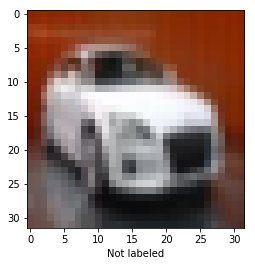

In [7]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(), sample_batched['label'])
    showImage(sample_batched['image'][0])
    #Check out the first batch
    break

In [8]:
showImage(batch1.getitem(6)['image'])

AttributeError: 'cifarDataset' object has no attribute 'getitem'

In [ ]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    print(dict.keys())
    return dict

In [ ]:
object = unpickle("./data/cifar-10-batches-py/data_batch_1") #Extract our dataset

In [ ]:
X = object[b'data']
X = X.reshape(len(object[b'data']),3,32,32) #Reshape to Color and the corresponding XY coordinates
X = X.transpose(0,2,3,1) #Transpose to X Y C

In [ ]:
showImage(X[2])